In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Data Processing

In [2]:
spotify = pd.read_csv("data.csv")
spotify.head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [3]:
#fix the artists column into the correct format

def artists(x):
    return x.replace("[", "").replace("]", "").replace("'", "").split(", ")

spotify['artists'] = spotify.agg({"artists": [artists]})['artists']

In [4]:
#make a new column indicating if the song was a collaboration

collab = []
for x in spotify['artists']:
    if len(x) > 1:
        collab.append(1)
    else:
        collab.append(0)

spotify['Collaboration'] = collab

In [5]:
#make a new column indicating what season the song was published in
season = []

for x in spotify['release_date']:
    
    split = x.split("-")
    if len(split) == 1:
        season.append("NA")
    else:
        month = int(split[1])
        if month == 12 or month <= 2:
            season.append("Winter")
        if month == 3 or month == 4 or  month == 5:
            season.append("Spring")
        if  month == 6 or  month == 7 or  month == 8:
            season.append("Summer")
        if  month == 9 or  month == 10 or month == 11:
            season.append("Fall")
            
spotify["Season"] = season

In [6]:
spotify.head(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,mode,name,popularity,release_date,speechiness,tempo,valence,year,Collaboration,Season
0,0.991,[Mamie Smith],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,...,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920,0,NA
1,0.643,"[""Screamin Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,...,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920,0,Winter
2,0.993,[Mamie Smith],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,...,1,Golfing Papa,4,1920,0.1740,97.600,0.689,1920,0,NA


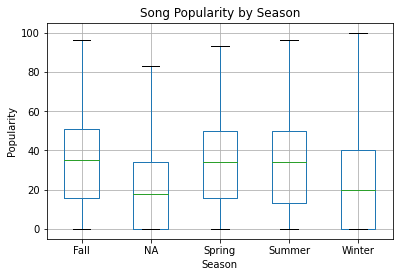

In [38]:
spotify[["Season", "popularity"]].boxplot(by = "Season")
plt.title('Song Popularity by Season')
plt.suptitle('')
plt.xlabel("Season")
plt.ylabel("Popularity")
plt.savefig("song_popularity.png", bbox_inches='tight', dpi=600)

In [8]:
#add the length of the song title (maybe longer song titles will be less effective since less memborable)
name_length = []

for x in spotify["name"]:
    name_length.append(len(x.split(" ")))

    
spotify['Name Length'] = name_length

In [9]:
#make song names lowercase
spotify['name'] = spotify['name'].str.lower()

In [10]:
#remove stopwords 
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

spotify['name'] = spotify['name'].apply(lambda x: " ".join([y for y in x.split() if y not in stop_words]))

In [11]:
from string import punctuation

def remove_punctuation(document):

    no_punct = ''.join([character for character in document if character not in punctuation])
    
    return no_punct

#remove punctuation
spotify['name'] = spotify['name'].apply(remove_punctuation)

In [12]:
#tokenize the text 

from nltk.tokenize import word_tokenize

names_tokenized = spotify['name'].apply(word_tokenize)

In [13]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def stemmer(document):
    
    stemmed_document = [porter.stem(word) for word in document]
    
    return stemmed_document

#apply the stemmer

name_stemmed = names_tokenized.apply(stemmer)

In [14]:
#detokenize 

from nltk.tokenize.treebank import TreebankWordDetokenizer

name_detokenized = name_stemmed.apply(TreebankWordDetokenizer().detokenize)

In [15]:
#vectorize the name column

from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(min_df = .02)

name = countvec.fit_transform(name_detokenized)
name

<174389x8 sparse matrix of type '<class 'numpy.int64'>'
	with 43801 stored elements in Compressed Sparse Row format>

In [47]:
name_dtm = pd.DataFrame(name.toarray(), columns=countvec.get_feature_names(), index=spotify.index)
name_dtm.head()

,live,love,mix,no,op,remast,version,year
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [17]:
final = pd.merge(spotify, name_dtm, left_index=True, right_index=True, how='outer')
final.to_csv("spotify_final.csv")

# Model Building: LDA

In [18]:
#prepare data for model building 

lda_data = pd.get_dummies(final, columns = ["Season"]).drop(columns = {"artists", "id", "name", \
                                                                       "release_date"})

#add binary column indicating if popularity score is above 25
popular = []
for x in lda_data['popularity'].astype('int32'):
    if x >= 25:
        popular.append(1)
    else:
        popular.append(0)
lda_data['popular'] = popular

In [19]:
#train test split

from sklearn.model_selection import train_test_split

y = lda_data['popular'].astype("int64")
x = lda_data.drop(['popular', "popularity"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.3,  
                                                    stratify=lda_data['popular'],
                                                    random_state=88,)
x_train.shape, x_test.shape

((122072, 29), (52317, 29))

In [20]:
#lda model

lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

y_prob_lda = lda.predict_proba(x_test)
y_pred_lda = pd.Series([1 if x > .5 else 0 for x in y_prob_lda[:,1]])

cm = confusion_matrix(y_test, y_pred_lda)
print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", accuracy_score(y_test, y_pred_lda))

Confusion Matrix: 
 [[18517  6932]
 [ 4163 22705]]

Accuracy: 0.7879274423227631


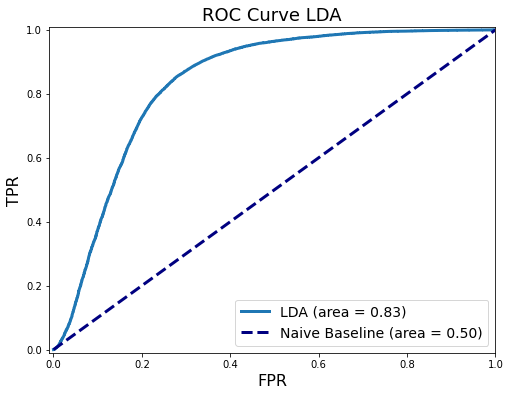

In [41]:
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda[:,1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve LDA', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lda, tpr_lda, lw=3, label='LDA (area = {:0.2f})'.format(roc_auc_lda))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.savefig("roc_lda.png", bbox_inches='tight', dpi=600)
plt.show()
